In [1]:
pwd

'/sdf/home/c/carsmith/flash_reconstruction/flash_detection'

In [2]:
import sys
sys.path.append('..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

In [3]:
# Loading in data
load_wfs = np.load('notebooks/class_reg_50k.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)
    waveforms = waveforms.unsqueeze(1)  # adding channel dimension

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (9000, 1000, 0)


In [4]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(hit_times[3].shape)

torch.Size([17])


/lscratch/carsmith/tmp/ipykernel_694428/3225775175.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


### Inspecting Data

hit_times: torch.Size([25, 17])
torch.Size([25, 1, 800])
torch.Size([25, 1, 800])


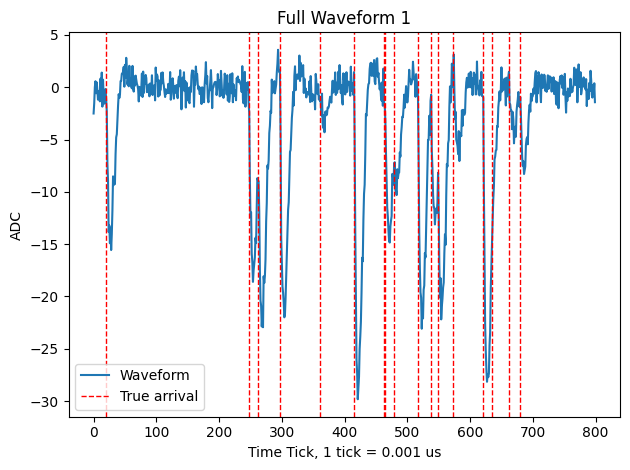

In [5]:
# Inspecting data
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

waveform_id = 1
wf = waveforms[waveform_id]

ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]

plt.plot(ticks, wf, alpha=1, label='Waveform')

# FOR MULTIPLE HITS!
for j, t in enumerate(hit_times[waveform_id]):
    plt.axvline(
        x=t.item(), 
        color='r', 
        linestyle='--', 
        linewidth=1, 
        label='True arrival' if j == 0 else ""
    )
plt.title(f"Full Waveform {waveform_id}")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Doing the training yuhh
from model import *
from utils import *
import torch.optim as optim
import wandb

epochs = 10
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="unet_class+reg",
    name="run0",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = UNet1D()
model.to(device)
wandb.watch(model, log="all", log_freq=100)

criterion = torch.nn.BCEWithLogitsLoss() # combines sigmoid + loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

mode = 'mined_bce'
results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "test.pth")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carsmith (carsmith-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Inspecting Classification Loss Calculation

In [7]:
model.eval()
train_progress = tqdm(val_loader, leave=False, position=0)
for i, (data, target, hit_times, photon_target, photon_list) in enumerate(train_progress):
    data, target, hit_times, photon_target = data.to(device), target.to(device), hit_times.to(device), photon_target.to(device) # model output is [25, 992] but target is [25, 1000] due to mismatch in downsampling/upsampling shapes
    class_output, reg_output = model(data)
    print(class_output.shape)
    break

epoch = 6
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(data, hit_times, photon_list, class_output, reg_output, epoch, device)

torch.Size([25, 1, 800])


Hit times: [533, 192, 730, 661, 571, 491, 179, 676, 611, 613, 36, 44, 31, 248, 426, 64, 425]
Sampled indices: [2, 14, 21, 31, 34, 36, 39, 44, 47, 50, 59, 64, 66, 70, 71, 81, 89, 100, 103, 109, 111, 117, 121, 128, 132, 141, 147, 152, 157, 162, 168, 177, 179, 180, 188, 190, 192, 193, 209, 213, 219, 220, 223, 231, 234, 235, 238, 247, 248, 268, 269, 270, 271, 272, 275, 276, 278, 279, 284, 288, 296, 298, 304, 309, 310, 318, 321, 323, 335, 336, 337, 360, 363, 370, 395, 405, 406, 407, 411, 412, 417, 425, 426, 431, 434, 441, 451, 454, 457, 462, 474, 481, 483, 489, 491, 493, 498, 503, 507, 508, 513, 516, 517, 518, 522, 529, 533, 534, 545, 546, 549, 550, 554, 561, 567, 571, 579, 582, 586, 588, 605, 607, 611, 613, 615, 617, 630, 637, 643, 656, 658, 660, 661, 664, 666, 668, 671, 673, 674, 676, 677, 689, 690, 696, 700, 705, 706, 707, 713, 720, 725, 726, 730, 739, 740, 745, 747, 749, 752, 762, 767, 773, 778, 785, 792, 796, 798]
True hit indices within masked: [3, 5, 7, 11, 32, 36, 48, 81, 82, 94, 10

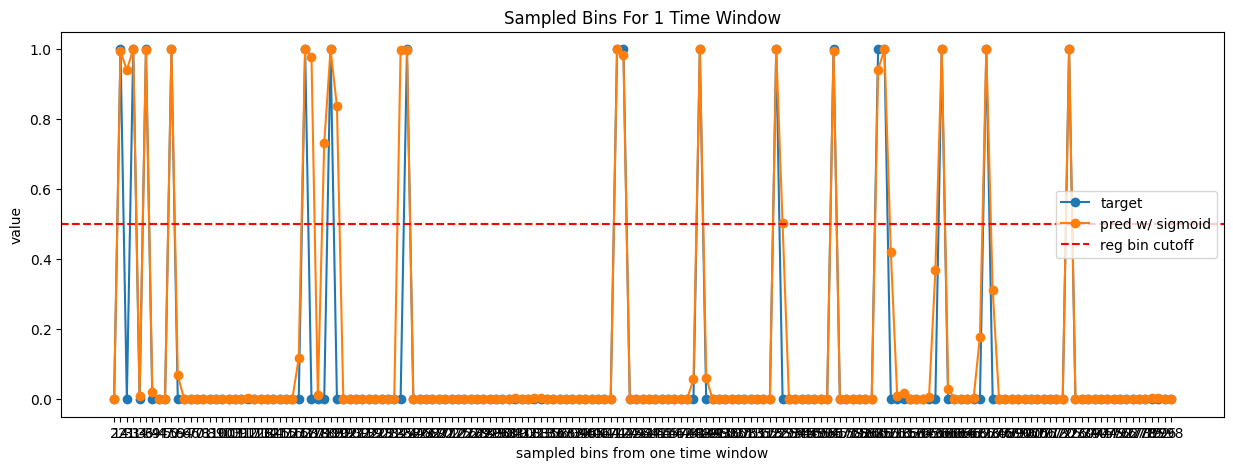

In [8]:
# Visualizing validation targets
# Inspecting Sampled Bins
waveform_id = 3
plt.figure(figsize=(15, 5))
plt.plot(masked_target[waveform_id*167:waveform_id*(167)+167].cpu(), marker='o', label='target')
plt.plot(torch.sigmoid(masked_output[waveform_id*167:waveform_id*(167)+167]).detach().cpu(), marker='o', label='pred w/ sigmoid')

hit_idx = hit_times[3].int()
mask = sampled_indices[3].cpu()
sampled_locs = torch.nonzero(mask).squeeze()
true_hit_locs_in_masked = [i for i, idx in enumerate(sampled_locs) if idx.item() in hit_idx.tolist()]

print("Hit times:", hit_idx.tolist())
print("Sampled indices:", sampled_locs.tolist())
print("True hit indices within masked:", true_hit_locs_in_masked)

indices = torch.nonzero(sampled_indices.cpu()[3] == True).squeeze().tolist()
plt.xticks(ticks=range(len(indices)), labels=indices)

plt.xlabel('sampled bins from one time window')
plt.ylabel('value')
plt.axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
plt.title('Sampled Bins For 1 Time Window')
plt.legend()
plt.show()

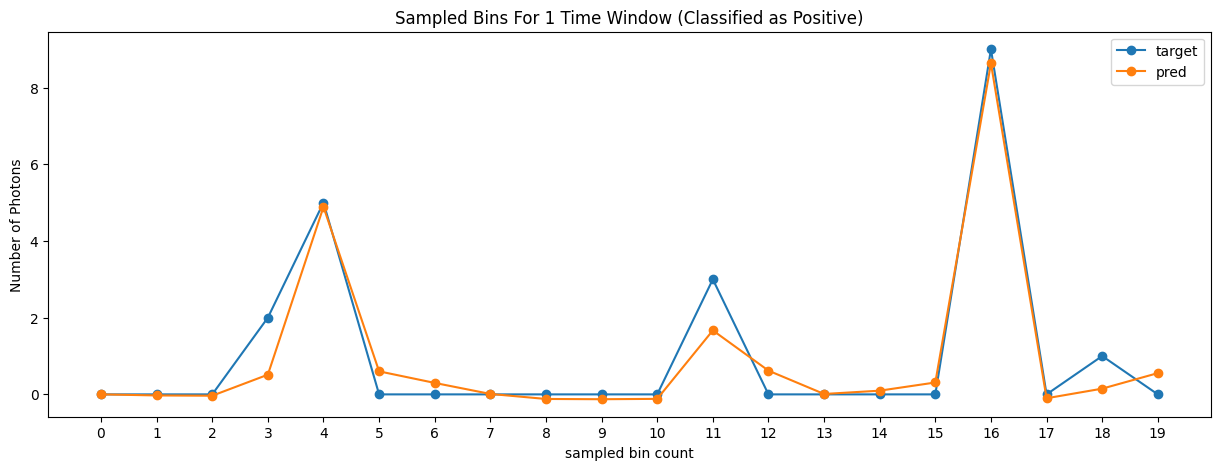

In [23]:
# Visualizing validation targets
# Inspecting Sampled Bins
waveform_id = 2
plt.figure(figsize=(15, 5))
plt.plot(masked_photon_target[waveform_id * 20: waveform_id * 20 + 20].cpu(), marker='o', label='target')
plt.plot(masked_reg_output[waveform_id * 20: waveform_id * 20 + 20].detach().cpu(), marker='o', label='pred')
# plt.plot(torch.sigmoid(masked_reg_output[waveform_id*167:waveform_id*(167)+167]).detach().cpu(), marker='o', label='pred w/ sigmoid')

# hit_idx = hit_times[3].int()
# mask = sampled_indices[3].cpu()
# sampled_locs = torch.nonzero(mask).squeeze()
# true_hit_locs_in_masked = [i for i, idx in enumerate(sampled_locs) if idx.item() in hit_idx.tolist()]

plt.xticks(np.arange(20))
plt.xlabel('sampled bin count')
plt.ylabel('Number of Photons')
# plt.axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
plt.title('Sampled Bins For 1 Time Window (Classified as Positive)')
plt.legend()
plt.show()

hit_times: torch.Size([25, 17])
torch.Size([25, 1, 800])
torch.Size([25, 1, 800])
torch.Size([25, 1, 800])
torch.Size([57, 2])


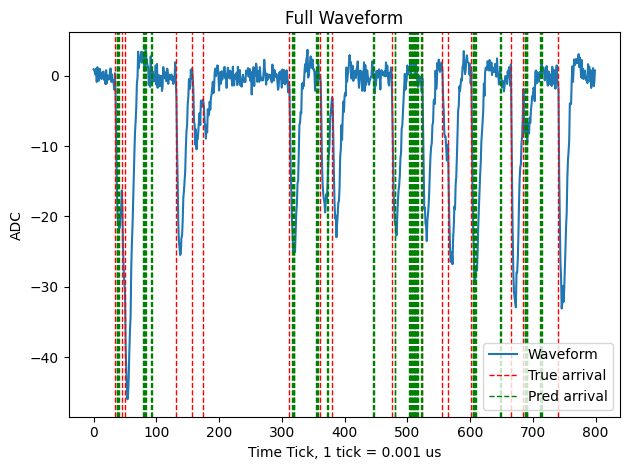

In [53]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
model.eval()
class_output, reg_output = model(data)

print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

waveform_id = 1
wf = waveforms[waveform_id]

ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]

plt.plot(ticks, wf, alpha=1, label='Waveform')

# FOR MULTIPLE HITS!
for j, t in enumerate(hit_times[waveform_id]):
    plt.axvline(
        x=t.item(), 
        color='r', 
        linestyle='--', 
        linewidth=1, 
        label='True arrival' if j == 0 else ""
    )

print(class_output.shape) # [batch_size, hits_per_batch]
mask = torch.sigmoid(class_output[waveform_id]) > 0.5
pred_hits = torch.nonzero(mask, as_tuple=False)
print(pred_hits.shape)

for j in range(pred_hits.shape[0]):
    plt.axvline(
        x=pred_hits[j, 1].cpu(),
        color='g',
        linestyle='--',
        linewidth=1,
        label='Pred arrival' if j == 0 else ""
    )

plt.title(f"Full Waveform")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()